In [7]:
import os
import glob

import spacy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [2]:
en = spacy.load('en_core_web_sm')

In [8]:
DATASETS_HOME = '../datasets'

train_df = pd.read_csv(os.path.join(DATASETS_HOME, 'home-depot/train.csv'))
train_df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [9]:
train_df.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [10]:
min_rel, max_rel = train_df['relevance'].min(), train_df['relevance'].max()
print(min_rel, max_rel)

1.0 3.0


In [11]:
X = train_df[['product_title', 'search_term', 'product_description']] 
y = train_df['relevance']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)

In [13]:
def preprocess(text):
    # TODO:
    # remove stopwords, etc.
    # try spacy stopwords, or something else
    return text


# TODO: Try BM25



tfidf_model = TfidfVectorizer(
    strip_accents='ascii',
    max_df=0.95,
    min_df=0.01,
    max_features=5000
).fit(X_train['product_description'])

In [11]:
def cosim(queries, candidates):  #, pairwise=True):
#     if not pairwise and queries.shape == candidates.shape:
#         dot = np.sum(queries.toarray() * candidates.toarray(), axis=1)
#         mag = np.linalg.norm(queries, axis=1) * np.linalg.norm(candidates, axis=1)
#         return dot / mag
    return cosine_similarity(queries, candidates)

In [12]:
def change_pred_range(pred, low=1.0, high=3.0):
    return pred / pred.max() * (high-low) + low

In [13]:
# MSE
def mse(pred, target):
    return np.mean((pred.diagonal() - target) ** 2)

In [14]:
# when using product title; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

0.7914314987881693

In [15]:
# when using product title; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['product_title'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

0.7528665862401178

In [16]:
# when using search term; train set
k = 5000

tfidf_candidates = tfidf_model.transform(X_train['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_train['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_train[:k])

1.392651381089793

In [17]:
# when using search term; test set
k = 5000

tfidf_candidates = tfidf_model.transform(X_test['product_description'])[:k]
tfidf_queries = tfidf_model.transform(X_test['search_term'])[:k]
y_pred = cosim(tfidf_queries, tfidf_candidates)

y_pred = change_pred_range(y_pred)
mse(y_pred, y_test[:k])

1.4010986658473683

In [18]:
# visual inspection of quality
# randomly sample about 20 examples

k = 20

idxs = np.random.randint(0, len(X_test), size=(k,))
X_test.iloc[idxs][['product_title', 'search_term', 'product_description']]

,product_title,search_term,product_description
55780,Barton Kramer Sliding Glass Door Handle,garge door handle,The Barton Kramer Sliding Glass Door Handle is...
16653,ArcMate 36 in. Industrial Orange Pick Up Reach...,reacher grabber,Professional Grade Pick-Up Tool uses rustproof...
15894,KOHLER Steward Waterless Urinal in White,urinal,Steward Waterless urinals provide significant ...
45347,FastenMaster 4 in. Heavy Duty Wood Screw (150-...,timberlok screws,"Save time, money and labor costs. TimberLoks s..."
12957,United Weavers Studio Red 7 ft. 10 in. x 10 ft...,united weavers,Cristall collection is a bold and high contras...
26844,Leviton 2-Gang Toggle Wall Plate - White,double outlet cover,Leviton offers a comprehensive selection of wa...
35405,Hampton Bay Nutmeg Simple Weave Rollup Shade,blinds for patio doors,The Nutmeg Simple Weave casual natural shade (...
52131,Home Legend Hand Scraped Maple Durham 3/8 in.T...,durham,Hand Scraped 3/8 in. High Density Fiberboard (...
21562,J-B Weld 2 oz. J-B SteelStik Epoxy Putty Stick,b&d .08 string spool,Repair or rebuild anything made of metal with ...
27200,Quikrete 20 lb. Quick-Setting Cement,quicker crete,Quikrete 20 lb. Quick-Setting Cement is a very...


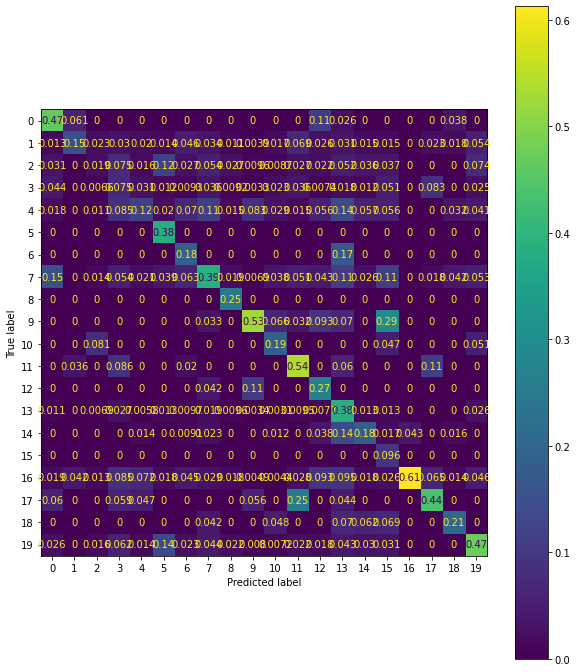

In [19]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['product_title'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

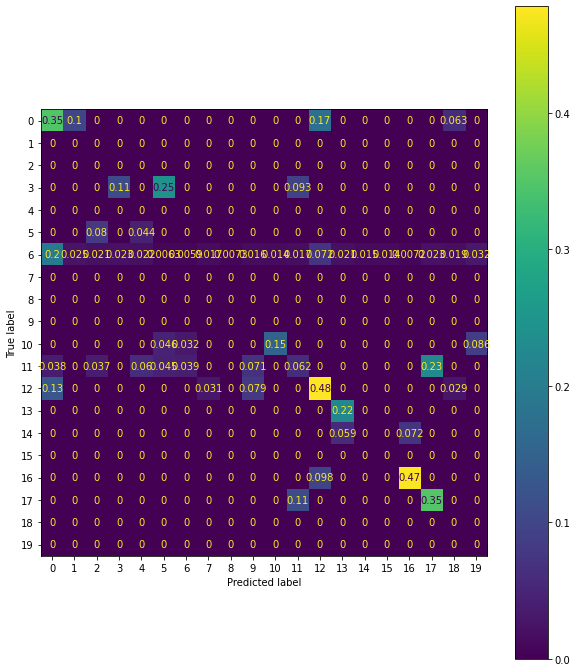

In [20]:
tfidf_candidates = tfidf_model.transform(X_test.iloc[idxs]['product_description'])
tfidf_queries = tfidf_model.transform(X_test.iloc[idxs]['search_term'])
y_pred_rand = cosim(tfidf_queries, tfidf_candidates)


ConfusionMatrixDisplay(y_pred_rand).plot()
fig = plt.gcf()
fig.set_size_inches(10, 12)
plt.show()

## Resume Dataset - 1

In [19]:
with open('./datasets/resume-corpus/jds.txt', 'r') as f:
    jds = f.read()

In [20]:
# all the text files
files = glob.glob('./datasets/resume-corpus/resumes_corpus/*.txt')
role_info = []
for file in files:
    with open(file, encoding='latin-1', errors='replace') as f:
        role_info.append(f.read())

In [21]:
# tfidf_model = TfidfVectorizer(
#     encoding='utf-8',
#     strip_accents='ascii',
#     max_df=0.90,
#     min_df=0.01,
#     max_features=4096
# ).fit(role_info)

tfidf_model_stopwords = TfidfVectorizer(
    encoding='utf-8',
    stop_words=en.Defaults.stop_words,
    strip_accents='ascii',
    max_df=0.90,
    min_df=0.01,
    max_features=4096
).fit(role_info)


# new_tfidf_model = TfidfVectorizer(
#     encoding='latin-1',
#     strip_accents='ascii',
#     decode_error='replace',
#     max_df=0.95,
#     min_df=0.01,
#     max_features=4096
# )

/home/kirito/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  warnings.warn(


In [134]:
# new_tfidf_model.vocabulary_ = tfidf_model.vocabulary_
# new_tfidf_model.fixed_vocabulary_ = tfidf_model.fixed_vocabulary_
# new_tfidf_model.idf_ = tfidf_model.idf_
# new_tfidf_model.stop_words_ = tfidf_model.stop_words_

In [28]:
candidate = tfidf_model_stopwords.transform(['Senior Systems Administrator'])
(candidate.toarray() == 0).sum()

4093

In [23]:
job_descriptions = {}

for i, jd in enumerate(jds.split('::::::\n::::::\n')):
    # first occurrence of ':::'
    idx1 = jd.find(':::')
    idx2 = jd.find(':::', idx1+3)
    role = jd[idx1+3: idx2].split(';')[0]
    job_descriptions[role] = role + ' ' + jd[idx2+3:]
    
#     print('Role:', role)
#     print('JD:', jd[idx2+3:])
#     if i == 2:
#         break

In [24]:
len(job_descriptions)

4

In [29]:
tfidf_candidates = tfidf_model_stopwords.transform(list(job_descriptions.values()))

In [30]:
(tfidf_candidates.toarray() == 0).sum()

15839

In [32]:
with open('./datasets/resume-corpus/resumes_corpus/00045.txt', errors='replace') as f:
    print(f.read())
    query = tfidf_model_stopwords.transform([f.read()],)
    
scores = cosine_similarity(query, tfidf_candidates)

COOK COOK COOK - SOUTHERN HILLS COUNTRY CLUB Tulsa, OK To gain an opportunity in field that allows for growth and advancement. Authorized to work in the US for any employer Work Experience COOK SOUTHERN HILLS COUNTRY CLUB March 2015 to Present Help to prepare and cook food that members order while maintaining food and health regulations. Assist in the training of new employees as needed. COOK REASORS February 2013 to March 2015 Cook and prep food while maintaining health and food regulations. DATABASE ADMINISTRATOR UNITED STATES MARINE CORPS April 2010 to January 2011 Monitor daily documentation, accountability, and qualifications of employees. Trained new employees regularly. AIRFRAME MECHANIC UNITED STATES MARINE CORPS October 2009 to January 2011 Repair and maintain the quality of the aircrafts. Serve Duty and watch as needed. Education BS in Game art and design Southern New Hampshire University July 2018 to July 2020 HIGH SCHOOL DIPLOMA June 2009 Skills Microsoft office (3 years) M

In [33]:
scores

array([[0., 0., 0., 0.]])